In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style> .container {width:96% !important;}</style>"""))

from IPython.display import IFrame

In [2]:
import pandas as pd
import numpy as np
# from plotly.offline import init_notebook_mode, iplot
# import cufflinks as cf
# init_notebook_mode()
# cf.go_offline()
from __future__ import division

In [3]:
import xgboost as xgb

In [4]:
import sys
sys.path.insert(0,'../')
from utils.paths import *

## Preprocessing

In [5]:
# Preprocessing
import preprocessing as pp
reload(pp)

<module 'preprocessing' from '../preprocessing.pyc'>

In [6]:
nat = pd.read_csv(path_SBA + 'SBAnational_new.csv', sep = ';', low_memory=False)
nat34 = nat[nat.ApprovalFY.isin([2003, 2004])].reset_index(drop = True)
nat5 = nat[nat.ApprovalFY.isin([2005])].reset_index(drop = True)

In [7]:
# Add job related features

# nat34
nat34['Expanding'] = nat34.CreateJob.apply(pp.expanding)
nat34['Retaining'] = nat34.CreateJob.apply(pp.retaining)
nat34['Expanding_ratio'] = nat34.apply(lambda x: pp.expanding_ratio(x['CreateJob'], x['NoEmp']), axis= 1)
nat34['Retaining_ratio'] = nat34.apply(lambda x: pp.retaining_ratio(x['RetainedJob'], x['NoEmp']), axis= 1)

# nat5
nat5['Expanding'] = nat5.CreateJob.apply(pp.expanding)
nat5['Retaining'] = nat5.CreateJob.apply(pp.retaining)
nat5['Expanding_ratio'] = nat5.apply(lambda x: pp.expanding_ratio(x['CreateJob'], x['NoEmp']), axis= 1)
nat5['Retaining_ratio'] = nat5.apply(lambda x: pp.retaining_ratio(x['RetainedJob'], x['NoEmp']), axis= 1)


In [8]:
use_col = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 
           'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 
           'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 
           'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 
           'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 
           'default', 'Zip5d', 'Zip3d', 'SBA_ratio', 'RealEstate', 
           'NAICS_default_rate', 'NAICS_group', 'suffix', 'Loan_age', 'Previous_loan', 'default_times',
           'fips', 'BusinessType',
           'Expanding', 'Retaining', 'Expanding_ratio', 'Retaining_ratio'
          ]


In [9]:
print nat34.shape, nat5.shape
nat34 = nat34[use_col]
nat5 = nat5[use_col]
print nat34.shape, nat5.shape
# nat[use_col].head().T

(126195, 50) (76957, 50)
(126195, 42) (76957, 42)


In [10]:
nat34.head()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,suffix,Loan_age,Previous_loan,default_times,fips,BusinessType,Expanding,Retaining,Expanding_ratio,Retaining_ratio
0,1005255000,Clark's Inc.,VISTA,CA,CALIFORNIA BANK & TRUST,CA,442210,2002-11-06,2003,2,...,INC,0,0,0,6073.0,CORPORATION,0,0,No change,No change
1,1005265003,James Byung Ho Park dba Parago,DOWNEY,CA,CALIFORNIA BANK & TRUST,CA,422990,2002-11-06,2003,83,...,NO SUFFIX,0,0,0,6037.0,INDIVIDUAL,0,0,No change,No change
2,1005275006,Danny W. Temple and Beau M. Te,MONTE VISTA,CO,CALIFORNIA BANK & TRUST,CA,561730,2002-11-06,2003,36,...,NO SUFFIX,0,0,0,8003.0,INDIVIDUAL,0,0,No change,No change
3,1005285009,"J & V Enterprises, LLC",COLORADO SPRINGS,CO,CALIFORNIA BANK & TRUST,CA,722211,2002-12-10,2003,36,...,LLC,0,0,0,8041.0,CORPORATION,0,0,No change,No change
4,1005295001,Susana Chung dba Law Offices o,LOS ANGELES,CA,CALIFORNIA BANK & TRUST,CA,541110,2002-12-10,2003,36,...,NO SUFFIX,0,0,0,6037.0,INDIVIDUAL,0,0,No change,No change


# Build machine learning model with the trainning set

## Train, Test split

In [11]:
from sklearn import model_selection
Train, Test = model_selection.train_test_split(nat34, 
                                               test_size = 0.25, 
                                               random_state = 1868,
                                               stratify = nat34.default 
                                               )

print Train.shape, Test.shape
print Train.default.sum(), Test.default.sum()
print Train.default.sum()/Train.shape[0], Test.default.sum()/Test.shape[0]


(94646, 42) (31549, 42)
15548 5183
0.16427529953722292 0.16428412944942788


In [12]:
print Train.columns.tolist()

['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'default', 'Zip5d', 'Zip3d', 'SBA_ratio', 'RealEstate', 'NAICS_default_rate', 'NAICS_group', 'suffix', 'Loan_age', 'Previous_loan', 'default_times', 'fips', 'BusinessType', 'Expanding', 'Retaining', 'Expanding_ratio', 'Retaining_ratio']


In [13]:
# Preprocessing train set
features = Train
target = Train.default

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

dict_categorical, features = pp.extract_train_features(features,
                                                    drop,
                                                    categorical)

print features.shape
print target.sum()

-----> Extract train features <------
dropping unwanted columns
transforming categorical variables
done
(94646, 26)
15548


In [14]:
features.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RealEstate,NAICS_default_rate,Loan_age,Previous_loan,default_times,...,Bank_INT,BankState_INT,RevLineCr_INT,LowDoc_INT,NAICS_group_INT,suffix_INT,fips_INT,BusinessType_INT,Expanding_ratio_INT,Retaining_ratio_INT
94281,1,1.0,0,1,1,0,22.0,0,0,0,...,523,40,1,0,7,20,1858,-1,1,2
80222,4,1.0,0,4,1,0,24.0,0,0,0,...,389,4,1,0,14,13,148,0,1,2
120325,1,1.0,3,4,1,0,21.0,0,0,0,...,1027,35,1,0,17,18,1450,0,0,2
112496,72,1.0,0,72,2,0,22.0,0,0,0,...,1027,35,0,0,18,16,1435,0,1,2
111901,18,1.0,0,18,2,0,23.0,0,0,0,...,523,40,1,0,4,13,250,0,1,2


In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, 
                                                                    target, 
                                                                    test_size = 0.25, 
                                                                    random_state=3776,
                                                                    stratify=target 
                                                                   )


dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, y_test.values)
num_rounds = 1100
# num_rounds = 2000

params = {'silent':1, 
          'eta':0.01, 
          'max_depth':11, 
          'subsample': 0.6, 
          'colsample_bytree': 0.4,
          'min_child_weight':1, 
          'objective':'binary:logistic', 
          'eval_metric':'auc', 
          'seed':2017, 
          'gamma':0.1,
          'nthread':-1}

watchlist = [(dtrain, 'train'),(dtest,'validation')]
bst=xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval = False);
num_rounds = bst.best_iteration
print num_rounds

937


In [16]:
# Use all the train data to train the model

X_train_matrix = features.values

#SKLEARN
clf_xgb = xgb.XGBClassifier(silent = params['silent'],
                            learning_rate = params['eta'],  
                            max_depth = params['max_depth'], 
                            subsample = params['subsample'], 
                            colsample_bytree = params['colsample_bytree'],
                            min_child_weight = params['min_child_weight'], 
                            objective = params['objective'], 
                            n_estimators = num_rounds,
                            seed = params['seed'],
                            nthread = params['nthread'],
                            gamma = params['gamma']
                                            )
clf_xgb.fit(X_train_matrix, 
            target, 
            eval_metric ='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=937, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2017, silent=1, subsample=0.6)

# Validate model with test set

In [17]:
# Preprocessing test set
test_X = Test.copy()
# Preprocessing

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

test_bas = pp.extract_test_features(test_X,
                                 drop,
                                 categorical,
                                 dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [23]:
# Prediction

for col in features.columns:
    if col not in test_bas.columns:
        print 'MISSING COLUMN: ',col
        
test_bas= test_bas[features.columns]
X_test_matrix = test_bas.values
print X_train_matrix.shape, X_test_matrix.shape

y_pred_xgb = clf_xgb.predict_proba(X_test_matrix)
temp = pd.DataFrame(y_pred_xgb)


(94646, 26) (31549, 26)


In [24]:
result_table_test = test_X[['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'State', 'default', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio']]
result_table_test.loc[:, 'prob'] = y_pred_xgb[:,1]


In [25]:
result_table_test.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.0,100000.0,50000.0,0.50,0.119180
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.0,50000.0,25000.0,0.50,0.145722
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.0,25000.0,12500.0,0.50,0.048208
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.0,100000.0,50000.0,0.50,0.217174
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.0,80000.0,68000.0,0.85,0.107566


In [26]:
import graphs as gg
reload(gg)

<module 'graphs' from '../graphs.pyc'>

Populating the interactive namespace from numpy and matplotlib


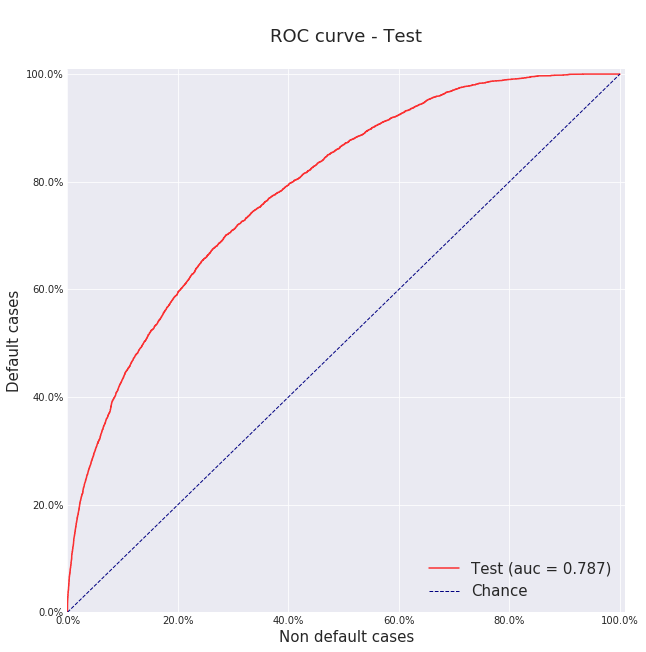

In [27]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
gg.plot_roc(result_table_test.default, result_table_test.prob, 'Test')

# Check model features

In [28]:
# Feature Importance

#BOOSTER
dtrain_ex=xgb.DMatrix(features.values,
                      label=target.values,
                      feature_names=features.columns)

bst_ex=xgb.train(params,
                 dtrain_ex,
                 num_boost_round=bst.best_iteration,
                 verbose_eval=False
                )
bst_ex.feature_names[:10]

['NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'UrbanRural',
 'RealEstate',
 'NAICS_default_rate',
 'Loan_age',
 'Previous_loan',
 'default_times']

In [29]:
def plot_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    xgb.plot_importance(feat_max, ax=ax)
    
def print_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    features_importance = pd.DataFrame([feat_max]).T
    features_importance = features_importance.rename(columns = {0: 'Score'})
    features_importance = features_importance.sort_values('Score', ascending=False)
    return features_importance

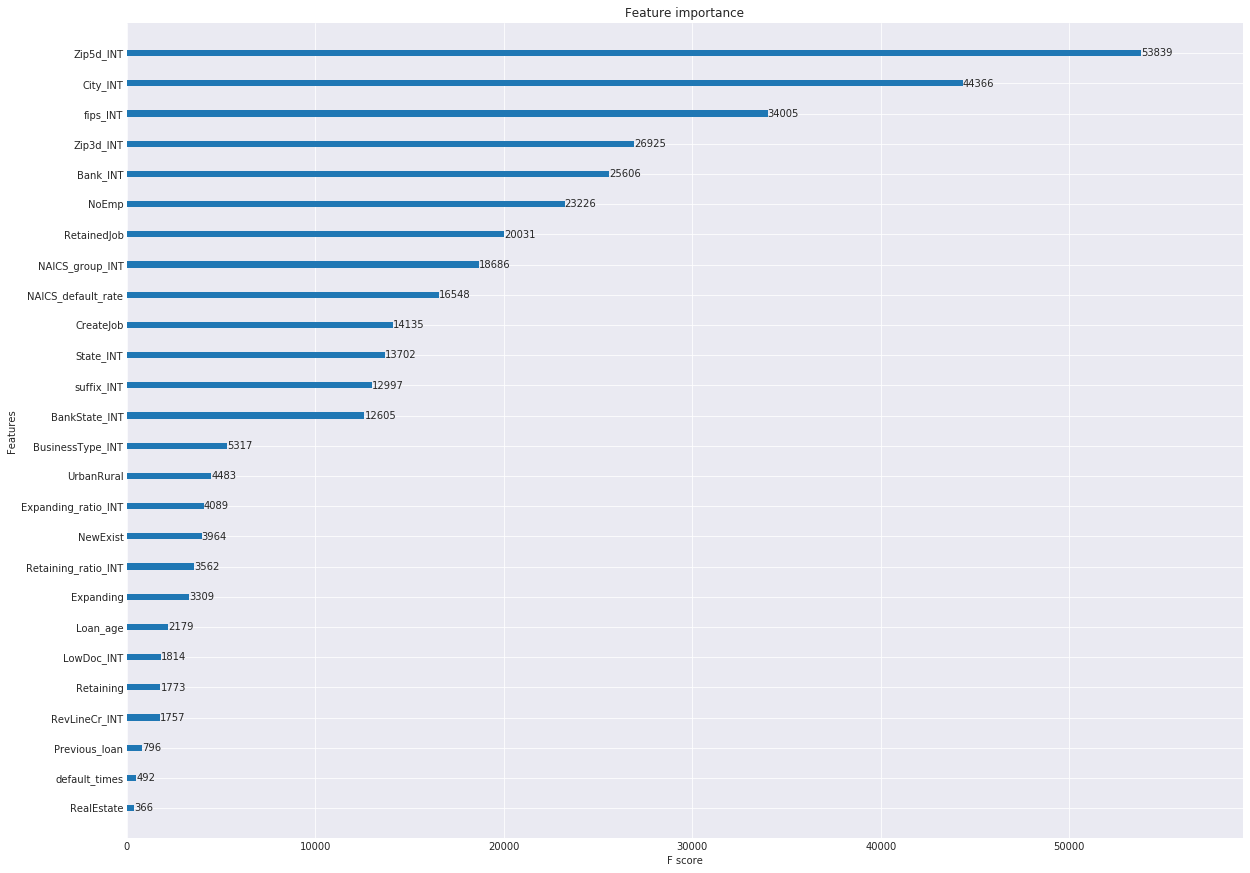

In [30]:
plot_features_importance(bst_ex)

In [31]:
feat_max = print_features_importance(bst_ex)
feat_max.rename(columns = {'Score': 'Accumlated score'}).head(15)

,Accumlated score
Zip5d_INT,53839
City_INT,44366
fips_INT,34005
Zip3d_INT,26925
Bank_INT,25606
NoEmp,23226
RetainedJob,20031
NAICS_group_INT,18686
NAICS_default_rate,16548
CreateJob,14135


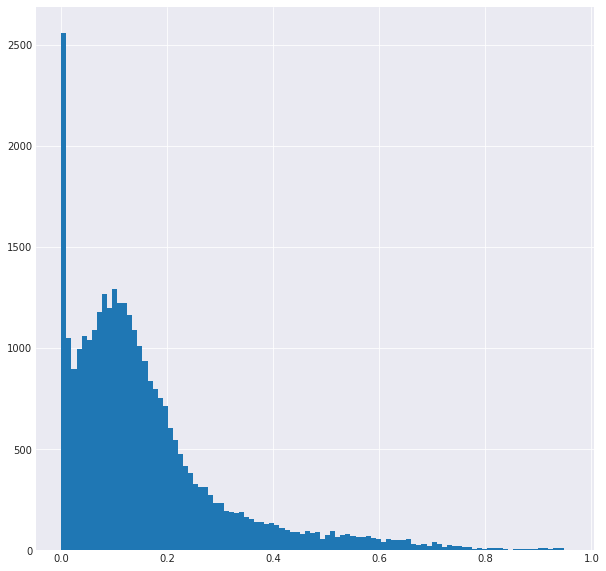

In [32]:
# Tuning grades

result_table_test.prob.hist(bins = 100)

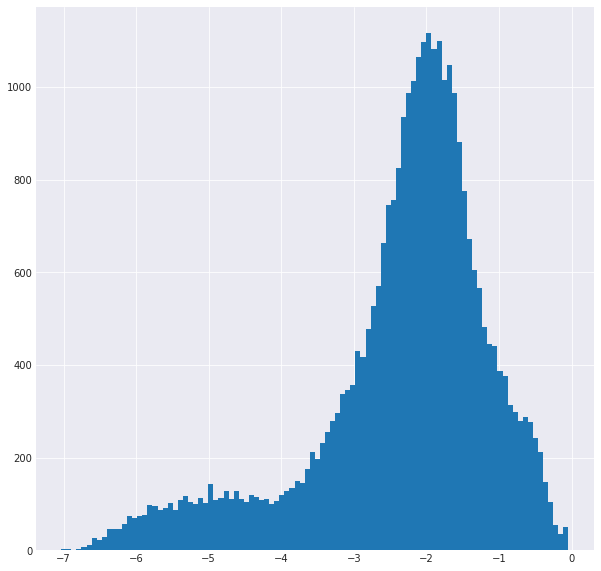

In [33]:
np.log(result_table_test.prob).hist(bins = 100)

# Assign grades using test set

In [34]:
# Tune grades based on percentile

def tuning_grades(num_grades, prob):
    Percentile = list(np.linspace(0, 100, num_grades+1))
    thresholds = [np.percentile(prob, i) for i in Percentile]
    thresholds[0] = 0
    thresholds[-1] = 1
    thresholds = [round(i, 3) for i in thresholds]
    return thresholds

prob_th = tuning_grades(5, result_table_test.prob)
prob_th

[0.0, 0.047, 0.099, 0.15, 0.235, 1.0]

In [35]:
grades = [str(g) for g in range(1,6)]

result_table_test.loc[:, 'Grade'] = pd.cut(result_table_test.prob, bins=prob_th, labels=grades)
result_table_test.loc[:, 'Grade'] = result_table_test['Grade'].astype('int')

In [36]:
result_table_test.Grade.value_counts().sort_index()

1    6365
2    6294
3    6289
4    6268
5    6333
Name: Grade, dtype: int64

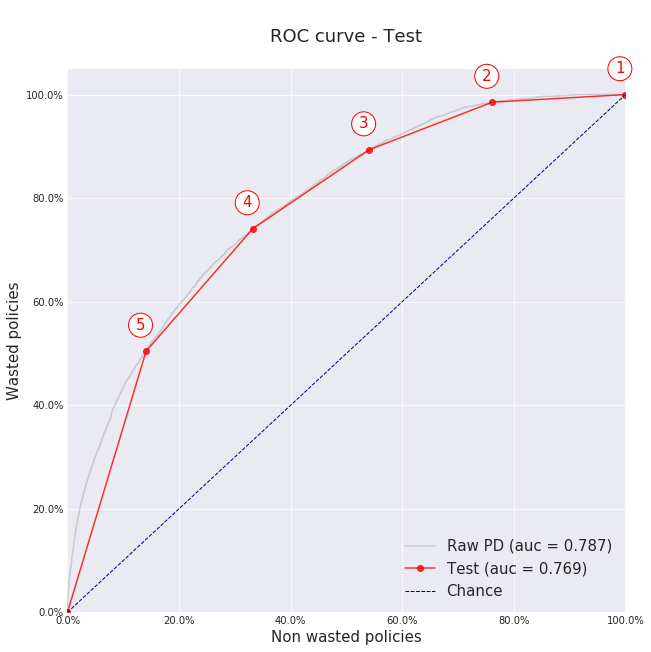

In [37]:
gg.plot_grade_roc(result_table_test.default, result_table_test.Grade, result_table_test.prob, 'Test')


In [38]:
result_table_test.groupby('Grade').default.sum()/result_table_test.Grade.value_counts()


1    0.011940
2    0.075628
3    0.125616
4    0.195597
5    0.412916
dtype: float64

# Apply machine learning model to 2005 data and predict defaults

In [40]:
Test.head()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,suffix,Loan_age,Previous_loan,default_times,fips,BusinessType,Expanding,Retaining,Expanding_ratio,Retaining_ratio
104760,7461474001,RELIANCE DATA INC,ARLINGTON,VA,BANK OF AMERICA NATL ASSOC,NC,541512,2004-05-24,2004,84,...,INC,0,0,0,51013.0,CORPORATION,1,1,Double size!,Over 80%
24578,6117344004,GILSON'S AUTO BODY SHOP,ALBUQUERQUE,NM,BANK OF AMERICA NATL ASSOC,NC,811111,2003-02-21,2003,84,...,NO SUFFIX,0,0,0,35001.0,INDIVIDUAL,1,1,Over 50%,Over 80%
124772,7824464009,ALL ABOUT KIDS INC,GRAND FORKS,ND,ALERUS FINANCIAL NATL ASSOC,ND,624410,2004-09-20,2004,84,...,INC,0,0,0,38035.0,CORPORATION,1,1,Over 50%,Over 80%
20754,6042984002,"HCD International, Inc.",LARGO,MD,BANK OF AMERICA NATL ASSOC,NC,541618,2003-01-23,2003,84,...,INC,0,0,0,24033.0,CORPORATION,1,1,No change,Over 80%
28924,6184124008,"PICKERINGTON EYE CARE, INC.",PICKERINGTON,OH,HEARTLAND BANK,OH,621320,2003-03-20,2003,60,...,INC,0,0,0,39045.0,CORPORATION,0,0,No change,No change


In [41]:
# Preprocessing test set
pred_X = nat5.copy()
# Preprocessing

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SBA_ratio',
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip5d', 'Zip3d', 'Bank', 'BankState', 'RevLineCr', 
               'LowDoc', 'NAICS_group', 'suffix', 'fips', 'BusinessType',
               'Expanding_ratio', 'Retaining_ratio'
              ]

pred_bas = pp.extract_test_features(pred_X,
                                    drop,
                                    categorical,
                                    dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [ ]:
# Prediction

for col in features.columns:
    if col not in pred_bas.columns:
        print 'MISSING COLUMN: ',col
        
pred_bas= pred_bas[features.columns]
X_pred_matrix = pred_bas.values
print X_train_matrix.shape, X_test_matrix.shape, X_pred_matrix.shape

y_pred_xgb = clf_xgb.predict_proba(X_pred_matrix)
temp = pd.DataFrame(y_pred_xgb)


# Financial Analysis

In [67]:
kernix_check.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob,Grade
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.0,100000.0,50000.0,0.50,0.104717,3
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.0,50000.0,25000.0,0.50,0.144876,3
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.0,25000.0,12500.0,0.50,0.053843,2
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.0,100000.0,50000.0,0.50,0.221781,4
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.0,80000.0,68000.0,0.85,0.099589,2


In [68]:
kernix_check.groupby('Grade').ChgOffPrinGr.sum()

Grade
1     11420497.0
2     46892750.0
3     60025357.0
4     91824161.0
5    109543263.0
Name: ChgOffPrinGr, dtype: float64

> For the banks, if they use machine learning to classify the loan then they may avoid some default especially for grade 5 companies.

In [69]:
def bank_loss(chgoffamount, sba_app):
    if chgoffamount == 0:
        return 0
    else:
        loss = chgoffamount - sba_app
        if loss < 0:
            loss = 0
        return loss
        
kernix_check.loc[:, 'Bank_loss'] = kernix_check.apply(lambda x: bank_loss(x['ChgOffPrinGr'], x['SBA_Appv']), axis = 1)

In [70]:
kernix_check.groupby('Grade').Bank_loss.sum()

Grade
1      681169.0
2     5232115.0
3     8787438.0
4    11850679.0
5    19552608.0
Name: Bank_loss, dtype: float64

> Given that some default is covered bny SBA, the actual loss for banks for each grade is much lower!

# National SBA 
(United States Small Business Administration)

SBA is a government agency and their objective is to help small business go through difficult period. 

Let's change the role of the SBA, let say they are an credit insurance provider and let's say they get 10% of providing insurance to the amount they insure.


In [71]:
kernix_check.groupby('Grade').SBA_ratio.mean()

Grade
1    0.772535
2    0.629208
3    0.620084
4    0.630414
5    0.629919
Name: SBA_ratio, dtype: float64

> It seem like the SBA is able to pick good company to guarantee loan but fail to avoid claim.

In [72]:
# Let's say the premium is 10% of the insure amount

kernix_check.groupby('Grade').SBA_ratio.mean()

Grade
1    0.772535
2    0.629208
3    0.620084
4    0.630414
5    0.629919
Name: SBA_ratio, dtype: float64

In [73]:
def sba_claim(chgoffamount, sba_app):
    if chgoffamount == 0:
        return 0
    else:
        if sba_app <= chgoffamount:
            claim = sba_app
        else:
            claim = chgoffamount
        return claim
    
kernix_check.loc[:, 'SBA_claim'] = kernix_check.apply(lambda x: sba_claim(x['ChgOffPrinGr'], x['SBA_Appv']), axis = 1)


In [74]:
# claim

kernix_check.groupby('Grade').SBA_claim.sum()

Grade
1    10739328.0
2    41660635.0
3    51237919.0
4    79973482.0
5    89990655.0
Name: SBA_claim, dtype: float64

In [75]:
# Premium

print 'Premium in each grade ' 
kernix_check.groupby('Grade').SBA_Appv.sum()*0.1

Premium in each grade 


Grade
1    213036926.0
2     62713029.7
3     51351660.9
4     50525530.7
5     31493091.6
Name: SBA_Appv, dtype: float64

In [76]:
# Gain and loss in each grade

kernix_check.groupby('Grade').SBA_Appv.sum()*0.1 - kernix_check.groupby('Grade').SBA_claim.sum()

Grade
1    202297598.0
2     21052394.7
3       113741.9
4    -29447951.3
5    -58497563.4
dtype: float64

In [77]:
# Total premium:
print 'Total premium: ', kernix_check.SBA_Appv.sum()*0.1
print 'Total claim  : ', kernix_check.SBA_claim.sum()
print 'Net profit:    ', kernix_check.SBA_Appv.sum()*0.1 - kernix_check.SBA_claim.sum()

Total premium:  409120238.90000004
Total claim  :  273602019.0
Net profit:     135518219.90000004


# Define new SBA ratio with machine learning grades

In [78]:
# Test.SBA_ratio.value_counts().sort_index()

def sba_ratio_ml(grade):
    new_ratio = {1: 1,
                 2: 0.8,
                 3: 0.6,
                 4: 0.4,
                 5: 0.2}
    return new_ratio[grade]

kernix_check.loc[:, 'SBA_ratio_ml'] = kernix_check.Grade.apply(sba_ratio_ml)
kernix_check.loc[:, 'SBA_Appv_ml'] = kernix_check.GrAppv * kernix_check.SBA_ratio_ml

In [79]:
# claim

kernix_check.loc[:, 'SBA_claim_ml'] = kernix_check.apply(lambda x: sba_claim(x['ChgOffPrinGr'], x['SBA_Appv_ml']), axis = 1)

kernix_check.groupby('Grade').SBA_claim_ml.sum()

Grade
1    11420497.0
2    44894321.0
3    49428265.0
4    55477322.2
5    32354309.8
Name: SBA_claim_ml, dtype: float64

In [80]:
# Premium

print 'Premium in each grade ' 
kernix_check.groupby('Grade').SBA_Appv_ml.sum()*0.1

Premium in each grade 


Grade
1    2.609230e+08
2    7.186091e+07
3    4.428018e+07
4    2.849778e+07
5    9.209083e+06
Name: SBA_Appv_ml, dtype: float64

In [81]:
# Gain and loss in each grade

kernix_check.groupby('Grade').SBA_Appv_ml.sum()*0.1 - kernix_check.groupby('Grade').SBA_claim_ml.sum()

Grade
1    2.495025e+08
2    2.696659e+07
3   -5.148084e+06
4   -2.697954e+07
5   -2.314523e+07
dtype: float64

In [82]:
# Total premium:
print 'Total premium: ', kernix_check.SBA_Appv_ml.sum()*0.1
print 'Total claim  : ', kernix_check.SBA_claim_ml.sum()
print 'Net profit:    ', kernix_check.SBA_Appv_ml.sum()*0.1 - kernix_check.SBA_claim_ml.sum()

Total premium:  414770940.08
Total claim  :  193574715.0
Net profit:     221196225.07999998


# Chart

In [83]:
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode()
cf.go_offline()

ImportError: No module named cufflinks

In [84]:
(kernix_check.groupby('Grade')[['SBA_Appv', 'SBA_Appv_ml']].sum()*0.1).iplot(kind = 'bar',
title = 'Premium change with machine learning', yTitle = 'USD', xTitle = 'Grades')

AttributeError: 'DataFrame' object has no attribute 'iplot'

In [142]:
(kernix_check.groupby('Grade')[['SBA_claim', 'SBA_claim_ml']].sum()).iplot(kind = 'bar',
title = 'Claim change with machine learning', yTitle = 'USD', xTitle = 'Grades')

# Result explaination

In [143]:
import eli5

In [144]:
eli5.show_weights(bst_ex, vec = dict_categorical, importance_type="weight")

Weight,Feature
0.1802,Zip5d_INT
0.1375,City_INT
0.0918,Bank_INT
0.0825,NoEmp
0.0671,Zip3d_INT
0.0634,RetainedJob
0.0555,NAICS_group_INT
0.0544,BankState_INT
0.0539,State_INT
0.0524,NAICS_default_rate


In [145]:
eli5.show_weights(bst_ex, vec = dict_categorical, importance_type="gain")

Weight,Feature
0.6346,RealEstate
0.0721,default_times
0.0593,RevLineCr_INT
0.0264,Bank_INT
0.0241,UrbanRural
0.0226,BankState_INT
0.0152,Previous_loan
0.0136,Loan_age
0.0115,State_INT
0.0110,LowDoc_INT


In [146]:
eli5.show_weights(bst_ex, vec = dict_categorical, importance_type="cover")

Weight,Feature
0.4101,RealEstate
0.2095,default_times
0.0684,Previous_loan
0.0488,RevLineCr_INT
0.0442,Loan_age
0.0264,UrbanRural
0.0250,BankState_INT
0.0240,Bank_INT
0.0159,NAICS_default_rate
0.0134,LowDoc_INT


## Explain individual 

In [71]:
eli5.show_prediction(bst_ex, test_bas.iloc[iloc], show_feature_values=True)

NameError: name 'iloc' is not defined

In [193]:
# kernix_check.head()
Test[Test.default == 1].head()

,LoanNr_ChkDgt,Name,City,State,Zip5d,Zip3d,Bank,BankState,NAICS,NAICS_group,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,default,RealEstate,SBA_ratio
71264,6920774003,RLB SADDLERY,SCOTT (TOWNSHIP OF),PA,15129,151,CITIZENS BANK NATL ASSOC,RI,423910,42,...,2003-12-31,55171.0,0.0,CHGOFF,27659.0,34000.0,17000.0,1,0,0.50
95879,7338694002,EDDIE'S AUTO PARTS AND GLASS,NEWPORT,AR,72112,721,CAPITAL ONE NATL ASSOC,VA,423120,42,...,2004-04-30,50000.0,0.0,CHGOFF,38238.0,50000.0,25000.0,1,0,0.50
74360,6986774006,BEARS LANDSCAPING & YARD DETAI,MANCHESTER,NH,3103,31,CITIZENS BANK NATL ASSOC,RI,541320,54,...,2004-01-31,35177.0,0.0,CHGOFF,30821.0,35000.0,17500.0,1,0,0.50
1247,1020445007,"G.W. Pools & Spas, Inc.",Salisbury,MA,1952,19,"TD BANK, NATIONAL ASSOCIATION",DE,238990,23,...,2004-08-31,30700.0,0.0,CHGOFF,14652.0,30700.0,15350.0,1,0,0.50
44214,6411294003,CEOPHAS & ASSOCIATES,LAUREL ACRES,MD,20724,207,BBCN BANK,CA,531210,53,...,2003-06-30,5000.0,0.0,CHGOFF,840.0,5000.0,4250.0,1,0,0.85


In [183]:
Test[Test.LoanNr_ChkDgt == 7461474001].iloc[[0]].index

Int64Index([104760], dtype='int64')

In [203]:
def explain_grade(loan_number, show_data = True, chart = True, model = bst_ex,
                  testset = Test, feeding_data = test_bas, result = kernix_check):
    testset = testset[testset.LoanNr_ChkDgt == loan_number]
    feeding_data = feeding_data.loc[testset.index]
    result = result[result.LoanNr_ChkDgt == loan_number]
#     display(testset)
#     display(feeding_data)
#     display(result)
#     display(eli5.show_prediction(model, feeding_data.iloc[0], show_feature_values=True))

    df = eli5.explain_prediction_df(model, feeding_data.iloc[0])
    feature_groups = {'Location': ['City_INT', 'UrbanRural', 'Zip3d_INT', 'Zip5d_INT', 'State_INT'],
                      'Sector': ['NAICS_group_INT', 'NAICS_default_rate'],
                      'Business': ['RealEstate', 'Franchise', 'NewExist'],
                      'Employees': ['CreateJob', 'RetainedJob', 'NoEmp'],
                      'Loan': ['BankState_INT', 'Bank_INT', 'LowDoc_INT', 'RevLineCr_INT']
                      }
    group_contribution = {}
    for k in feature_groups.keys():
        group_contribution[k] = df[df.feature.isin(feature_groups[k])].weight.sum()
    return group_contribution
x = explain_grade(6920774003)

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,ChgOffPrinGr,GrAppv,SBA_Appv,SBA_ratio,prob,Grade,Bank_loss,SBA_claim,SBA_ratio_ml,SBA_Appv_ml,SBA_claim_ml
71264,6920774003,RLB SADDLERY,2004,PA,1,27659.0,34000.0,17000.0,0.5,0.19008,4,10659.0,17000.0,0.4,13600.0,13600.0


In [204]:
x

{'Business': 0.14575622285673298,
 'Employees': 0.16597186327805954,
 'Loan': 0.046952147119562387,
 'Location': -0.055741784709688172,
 'Sector': -0.081251933705464824}

In [198]:
feature_groups = {'Location': ['City_INT', 'UrbanRural', 'Zip3d_INT', 'Zip5d_INT', 'State_INT'],
                  'Sector': ['NAICS_group_INT', 'NAICS_default_rate'],
                  'Business': ['RealEstate', 'Franchise', 'NewExist'],
                  'Employees': ['CreateJob', 'RetainedJob', 'NoEmp'],
                  'Loan': ['BankState_INT', 'Bank_INT', 'LowDoc_INT', 'RevLineCr_INT']
                  }

In [201]:
x[x.feature.isin(feature_groups['Location'])].weight.sum()

-0.055741784709688172

In [167]:
test_bas.head()

,NAICS_default_rate,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RealEstate,Franchise,City_INT,State_INT,Zip5d_INT,Zip3d_INT,Bank_INT,BankState_INT,RevLineCr_INT,LowDoc_INT,NAICS_group_INT
104760,19.0,2,1.0,6,2,1,0,0,274.0,45,4099.0,200.0,194.0,28,1,0.0,12
24578,20.0,2,1.0,2,2,1,0,0,84.0,32,13889.0,800.0,194.0,28,1,0.0,19
124772,10.0,2,2.0,3,5,1,0,0,3375.0,28,9707.0,539.0,72.0,29,1,0.0,16
20754,19.0,30,1.0,2,32,1,0,0,4672.0,20,3858.0,186.0,194.0,28,0,0.0,12
28924,10.0,5,1.0,0,0,1,0,0,6867.0,35,7044.0,398.0,1240.0,36,0,1.0,16


In [69]:
kernix_check.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,prob,Grade,ChgOffPrinGr,SBA_ratio,SBA_Appv,Bank_loss,SBA_claim,SBA_ratio_ml
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.124421,3,0.0,0.50,50000.0,0.0,0.0,0.6
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.121012,3,0.0,0.50,25000.0,0.0,0.0,0.6
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.084028,2,0.0,0.50,12500.0,0.0,0.0,0.8
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.210395,4,0.0,0.50,50000.0,0.0,0.0,0.4
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.131635,3,0.0,0.85,68000.0,0.0,0.0,0.6


In [83]:
Test[Test.default == 1].sample(10).T

,85252,30159,38864,39227,106939,50215,66701,111219,3762,5490
LoanNr_ChkDgt,7176914003,6201084001,6321764009,6327264002,7492124004,6513334003,6818344007,7555594003,1050585004,1071345001
Name,NORTHEAST WINDOWS INC,DULCINEA,CARIBBEAN STYLE INC,PINAULT HARDWARE COMPANY,UNCLE LARRY'S TOY SHOP,BABY LAND,VEGAS WHOLESALE JEWELER,B & I AUTO COLLISION LLC,Charles D. Byers DBA Mission C,Chuy's Campbell L.L.C.
City,WOODRIDGE,DALLAS,MIAMI,WOONSOCKET,CHARLOTTESVILLE,OKLAHOMA CITY,LAS VEGAS,REDFORD TOWNSHIP,San Antonio,TUCSON
State,NY,TX,FL,RI,VA,OK,NV,MI,TX,AZ
Zip5d,12789,75215,33172,2895,22903,73132,89103,48239,78233,85719
Zip3d,127,752,331,28,229,731,891,482,782,857
Bank,HSBC BK USA NATL ASSOC,JPMORGAN CHASE BANK NATL ASSOC,BANK OF AMERICA NATL ASSOC,CITIZENS BANK NATL ASSOC,BBCN BANK,BANCFIRST,BANK OF AMERICA NATL ASSOC,"PNC BANK, NATIONAL ASSOCIATION",CAPITAL ONE NATL ASSOC,BANK OF AMERICA NATL ASSOC
BankState,VA,IL,NC,RI,CA,OK,NC,DE,VA,NC
NAICS,423310,446120,811212,444130,451120,448130,421940,811121,339999,722110
NAICS_group,42,44,81,44,44,44,42,81,31,72


In [209]:
!ls ../large_data_files/ASA_loan_data/

SBAcase_11_13_17.csv SBAnational.csv      SBAnational_new.csv
